~~~
Copyright 2026 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~

# Analyze Whole Slide Digital Pathology Imaging with MedGemma 1.5

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/medgemma/blob/main/notebooks/high_dimensional_pathology_model_garden.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogle-Health%2Fmedgemma%2Fmain%2Fnotebooks%2Fhigh_dimensional_pathology_model_garden.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/medgemma/blob/main/notebooks/high_dimensional_pathology_model_garden.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/collections/google/medgemma-release-680aade845f90bec6a3f60c4">
      <img alt="Hugging Face logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on Hugging Face
    </a>
  </td>
</tr></tbody></table>

This notebook demonstrates how to use digital pathology whole slide images to prompt MedGemma 1.5 running on Vertex AI. This notebook is for educational purposes only to show the baseline functionality of MedGemma 1.5. It does not represent a finished or approved product, is not intended to diagnose or suggest treatment for any disease or condition, and should not be used for medical advice. See [HAI-DEF Terms of Use](https://developers.google.com/health-ai-developer-foundations/terms) for more information.

Vertex AI makes it easy to serve your model and make it accessible to the world. Learn more about [Vertex AI](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform).

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

In [ ]:
# @title Install [ez-wsi-dicomweb](https://colab.sandbox.google.com/github/GoogleCloudPlatform/EZ-WSI-DICOMweb/blob/main/ez_wsi_demo.ipynb) Python library

%%capture
! pip install ez-wsi-dicomweb==6.1.5

In [ ]:
# @title Authenticate with Google Cloud (only needed for Google Colab)

import os
import sys

google_colab = "google.colab" in sys.modules and not os.environ.get("VERTEX_PRODUCT") == "COLAB_ENTERPRISE"

if google_colab:
    from google.colab import auth
    # There will be a popup asking you to sign in with your user account and approve
    # access
    auth.authenticate_user()

## Retrieve Imaging Data Commons (IDC) Digital Pathology Imaging Metadata

[Imaging Data Commons (IDC)](https://datacommons.cancer.gov/repository/imaging-data-commons#) is one of the largest publicly available, de-identified, repositories for cancer imaging. The repository is funded by the [National Cancer Institute (NCI)](https://www.cancer.gov/), an institute of the [National Institutes of Health (NIH)](https://www.nih.gov/), a part of the [U.S. Department of Health and Human Service](https://www.hhs.gov/). IDC contains images for all major medical imaging modalities. Images are stored within the archive as [DICOM](https://www.dicomstandard.org/). Images and associated metadata can be searched and visualized through the [IDC website](https://portal.imaging.datacommons.cancer.gov/explore/) or [BigQuery](https://cloud.google.com/healthcare-api/docs/resources/public-datasets/idc), and can be accessed using DICOMweb ([IDC tutorial](https://learn.canceridc.dev/data/downloading-data/dicomweb-access)). For the purposes of this notebook we have mirrored the required images in a Google DICOM store.


### [DICOM Information Model](https://learn.canceridc.dev/dicom/data-model)
[DICOM](https://www.dicomstandard.org/) uniquely identifies imaging using three UIDs: Study Instance UID, Series Instance UID, and a SOP Instance UID. Conceptually, a Study Instance UID can be thought of as the UID that identifies all images acquired or generated as a result of a patient exam. Each medical image acquired as part of the exam (e.g., unique digital pathology image) is identified by a unique Series Instance UID. Each image acquired or generated as part of the an acquisition is, in turn, identified with a unique SOP Instance UID.

At its highest magnifications digital pathology images are gigapixel. To enable these images to be rapidly panned and zoomed they are commonly stored as an image pyramid. Each level of the pyramid is stored as a unique image. The colab requests imaging from the the pyramid level that describes imaging at a 10x magnfication.

In [ ]:
from ez_wsi_dicomweb import credential_factory
from ez_wsi_dicomweb.ml_toolkit import dicom_path
from ez_wsi_dicomweb import dicom_web_interface
from ez_wsi_dicomweb import dicom_slide
from ez_wsi_dicomweb import pixel_spacing

# This notebook uses images hosted in the Imaging Data Commons (IDC) archive
# This notebook utilizes data generated by the National Cancer Institute.
# Collection: The Cancer Genome Atlas Colon Adenocarcinoma Collection (TCGA-COAD)
# Specimen: TCGA-A6-2678
study_instance_uid = "2.25.235417235028353173678913601557627156136"
series_instance_uid = "1.3.6.1.4.1.5962.99.1.3212613380.1372214266.1639595185924.2.0"

# Read DICOM instance metadata for images
series = f"https://healthcare.googleapis.com/v1/projects/hai-cd3-foundations/locations/us-central1/datasets/public/dicomStores/test-images/dicomWeb/studies/{study_instance_uid}/series/{series_instance_uid}"
cf = credential_factory.DefaultCredentialFactory()
dwi = dicom_web_interface.DicomWebInterface(cf)
slide = dicom_slide.DicomSlide(dwi, dicom_path.FromString(series))
slide.init_slide_frame_cache()

# Retrieve images from pathology imaging which is ~10x
level = slide.get_level_by_pixel_spacing(pixel_spacing.PixelSpacing.FromMagnificationString("10X"))


Low magnfication view of the slide imaging.


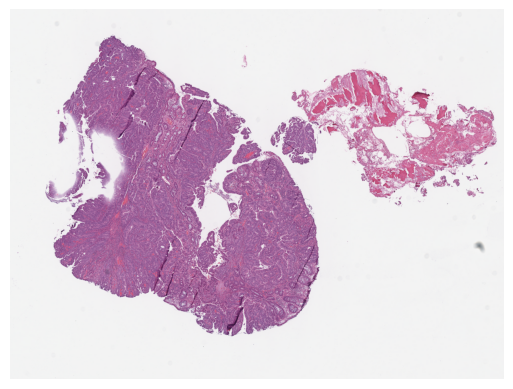

Visualization of 3 patches randomly sampled from ~10x imaging


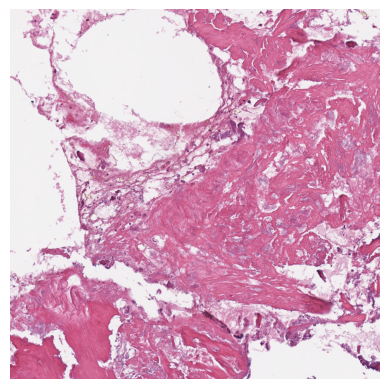

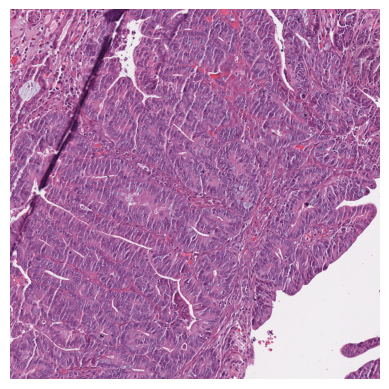

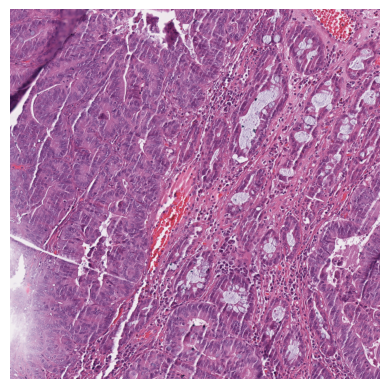

In [ ]:
# @title Visualize patches of digital pathology images from the DICOM store

import random

from ez_wsi_dicomweb import patch_generator
import matplotlib.pyplot as plt


# Maximum number of patches to retrieve from the slide imaging.
maximum_number_of_patches = 125
patch_size = 896  # MedGemma input image size.

# Generate patches from non-overlapping tissue containing regions.
patche_generator = patch_generator.DicomPatchGenerator(slide, level, patch_size=patch_size, stride_size=patch_size)
sampled_patches = [p for p in patche_generator]
sampled_patches = random.sample(sampled_patches, k=min(maximum_number_of_patches, len(sampled_patches)))

print("Low magnfication view of the slide imaging.")
plt.imshow(patche_generator.get_tissue_mask())
plt.axis("off")
plt.show()

print("Visualization of 3 patches randomly sampled from ~10x imaging")
for p in sampled_patches[:min(3, len(sampled_patches))]:
   plt.imshow(p.image_bytes()) # Display the image with a grayscale colormap
   plt.axis("off") # Optional: Turn off axis labels and ticks
   plt.show()

## Construct MedGemma 1.5 prompt formatted as Chat Completion

In [ ]:
prompt = ("You are an instructor teaching medical students. For education "
          "purposes, provide a brief descriptive text for the set of pathology "
          "patches extracted from a pathology slide. Consider the tissue type "
          "and procedure (below) when deciding what to include in the "
          "descriptive text.\ncolon, biopsy:")

dicom_source = f'{series}/instances/{level.get_level_sop_instance_uids()[0]}'
patch_coordinates_list = [{"x_origin": p.x,
                           "y_origin": p.y,
                           "width": p.width,
                          "height": p.height} for p in sampled_patches
                        ]

content = [{"type": "text", "text": prompt}]
content.append({"type": "image_dicom",
                "image_dicom": {
                    "dicom_source": dicom_source,
                    "access_credential": cf.get_credentials().token,
                    "patch_coordinates_list": patch_coordinates_list
                }
              })

instance = {
        "@requestFormat": "chatCompletions",
        "messages": [{"role": "user", "content": content}],
        "max_tokens": 500,
        "temperature": 0
}

In [ ]:
# @title Display full MedGemma 1.5 prompt.
import json
from IPython.display import display, Markdown


def mask_bearer_token(obj):
  """Masks bearer token."""
  if isinstance(obj, dict):
    return {k: mask_bearer_token(v) if k != 'access_credential' else 'TOKEN' for k, v in obj.items()}
  elif isinstance(obj, list):
    return [mask_bearer_token(elem) for elem in obj]
  return obj


txt = json.dumps(mask_bearer_token(instance), indent=4, sort_keys=True)
display(Markdown(f"```json\n{txt}"))

```json
{
    "@requestFormat": "chatCompletions",
    "max_tokens": 500,
    "messages": [
        {
            "content": [
                {
                    "text": "You are an instructor teaching medical students. For education purposes, provide a brief descriptive text for the set of pathology patches extracted from a pathology slide. Consider the tissue type and procedure (below) when deciding what to include in the descriptive text.\ncolon, biopsy:",
                    "type": "text"
                },
                {
                    "image_dicom": {
                        "access_credential": "TOKEN",
                        "dicom_source": "https://healthcare.googleapis.com/v1/projects/nci-idc-data/locations/us-central1/datasets/idc/dicomStores/idc-store-v21/dicomWeb/studies/2.25.235417235028353173678913601557627156136/series/1.3.6.1.4.1.5962.99.1.3212613380.1372214266.1639595185924.2.0/instances/1.3.6.1.4.1.5962.99.1.3212613380.1372214266.1639595185924.22.0",
                        "patch_coordinates_list": [
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 6272,
                                "y_origin": 1792
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 2688,
                                "y_origin": 1792
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 1792,
                                "y_origin": 1792
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 4480,
                                "y_origin": 1792
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 2688,
                                "y_origin": 2688
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 896,
                                "y_origin": 896
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 5376,
                                "y_origin": 896
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 1792,
                                "y_origin": 2688
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 4480,
                                "y_origin": 3584
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 2688,
                                "y_origin": 3584
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 4480,
                                "y_origin": 2688
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 896,
                                "y_origin": 2688
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 2688,
                                "y_origin": 896
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 1792,
                                "y_origin": 3584
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 5376,
                                "y_origin": 1792
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 3584,
                                "y_origin": 4480
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 3584,
                                "y_origin": 3584
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 3584,
                                "y_origin": 1792
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 1792,
                                "y_origin": 896
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 3584,
                                "y_origin": 2688
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 2688,
                                "y_origin": 4480
                            },
                            {
                                "height": 896,
                                "width": 896,
                                "x_origin": 896,
                                "y_origin": 3584
                            }
                        ]
                    },
                    "type": "image_dicom"
                }
            ],
            "role": "user"
        }
    ],
    "temperature": 0
}

In [ ]:
# @title ## Set up Google Cloud environment and MedGemma 1.5 Vertex AI endpoint

# @markdown #### Prerequisites
# @markdown
# @markdown 1. Make sure that [billing is enabled](https://cloud.google.com/billing/docs/how-to/modify-project) for your project.
# @markdown
# @markdown 2. Make sure that either the Compute Engine API is enabled or that you have the [Service Usage Admin](https://cloud.google.com/iam/docs/understanding-roles#serviceusage.serviceUsageAdmin) (`roles/serviceusage.serviceUsageAdmin`) role to enable the API.
# @markdown
# @markdown This section sets the default Google Cloud project and enables the Compute Engine API (if not already enabled), and initializes the Vertex AI API.

import os
from google.cloud import aiplatform

Google_Cloud_Project = ""  # @param {type: "string", placeholder:"e.g. MyProject"}

# @markdown To get [online inferences](https://cloud.google.com/vertex-ai/docs/predictions/get-online-predictions), you will need a MedGemma 1.5 [Vertex AI endpoint](https://cloud.google.com/vertex-ai/docs/general/deployment) that has been deployed from Model Garden. If you have not already done so, go to the [MedGemma model card](https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/medgemma) and click **"Deploy model"** to deploy the model.
# @markdown
# @markdown **Note:**
# @markdown - This notebook is intended to be used with MedGemma 1.5. Make sure to deploy and use a MedGemma 1.5 endpoint that is configured with an image limit of at least 125 images (in the Model Garden **"Deploy options"** panel, check the image limit under **"Deployment Settings" > "Serving spec"**).
# @markdown - This notebook requires a [dedicated Vertex AI endpoint](https://cloud.google.com/vertex-ai/docs/predictions/choose-endpoint-type). Dedicated endpoints are the default endpoint type for Model Garden deployments.

# @markdown This section gets the Vertex AI endpoint resource that you deployed from Model Garden to use for online inferences.
# @markdown
# @markdown Fill in the endpoint ID and region below. You can find your deployed endpoint on the [Vertex AI endpoints page](https://console.cloud.google.com/vertex-ai/online-prediction/endpoints).

ENDPOINT_ID = ""  # @param {type: "string", placeholder:"e.g. 123456789"}
ENDPOINT_REGION = ""  # @param {type: "string", placeholder:"e.g. us-central1"}

os.environ["CLOUDSDK_CORE_PROJECT"] = Google_Cloud_Project
os.environ["GOOGLE_CLOUD_PROJECT"] = Google_Cloud_Project
os.environ["GOOGLE_CLOUD_REGION"] = ENDPOINT_REGION

# Enable the Compute Engine API, if not already.
print("Enabling Compute Engine API.")
! gcloud services enable compute.googleapis.com

# Initialize Vertex AI API.
print("Initializing Vertex AI API.")
aiplatform.init(project=os.environ["GOOGLE_CLOUD_PROJECT"],
                location=os.environ["GOOGLE_CLOUD_REGION"],
                api_transport="rest")

endpoint = aiplatform.Endpoint(
    endpoint_name=ENDPOINT_ID,
    project=Google_Cloud_Project,
    location=ENDPOINT_REGION,
)

# Use the endpoint name to check that you are using an appropriate model variant.
# These checks are based on the default endpoint name from the Model Garden
# deployment settings.
ENDPOINT_NAME = endpoint.display_name
# Check that "1.5" (formatted as "1_5") is in the endpoint name
if "1_5" not in ENDPOINT_NAME:
    raise ValueError(
        "The examples in this notebook are intended to be used with MedGemma "
        "1.5. Please deploy and use an endpoint with the MedGemma 1.5 model."
    )

Enabling Compute Engine API.
Initializing Vertex AI API.


In [ ]:
# @title Call MedGemma 1.5 and return prediction

response = endpoint.raw_predict(
    body=json.dumps(instance).encode("utf-8"), use_dedicated_endpoint=True,
    headers={"Content-Type": "application/json"}
)
response.raise_for_status()
response = endpoint.raw_predict(
    body=json.dumps(instance).encode('utf-8'), use_dedicated_endpoint=True,
    headers={'Content-Type': 'application/json'}
)
response.raise_for_status()
medgemma_response = response.json()
try:
  medgemma_response = medgemma_response["choices"][0]["message"]["content"]
  display(Markdown(f"---\n\n**[ MedGemma ]**\n\n{medgemma_response}\n\n---"))
except KeyError:
  print(medgemma_response["error"])

---

**[ MedGemma ]**

colonic adenocarcinoma.
 histologic grade: moderately differentiated.
 deepest invasion: through muscularis propria.
 tumor border: infiltrative.
 angiolymphatic invasion: identified.

---

## Next steps

Explore the other [notebooks](https://github.com/google-health/medgemma/blob/main/notebooks) to learn what else you can do with the model.